# Loans Dataset
### Library imports and setting up the environment

In [145]:

import os, sys, pandas as pd, numpy as np
import matplotlib.pyplot as plt
seed=1234
sys.path.append(os.path.abspath('D:\Python WD\codebase'))
from my_utilities import functions
from my_utilities import eda_utilities
import importlib
importlib.reload(functions)
os.getcwd()
os.chdir("D:\Python WD\profit_maximizing_classifier")
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from local_functions import tune_estimators

### Data load
- data reading
- data type conversion to required format
- rename target variables to represent 1 as positive class(bad loan) and 0 as negative class

In [146]:
###################################################################################
"""data load"""
dictionary= pd.read_excel("data/auto-encoder data/dictionary.xlsx", sheet_name='dictionary')
dataset= pd.read_csv("data/auto-encoder data/bene1cont.txt", sep='\t', header= None)
dataset.columns= dictionary['Name'].to_list()
dictionary.loc[dictionary['Type']=='continuous','Dtype']= 'float'
dictionary.loc[dictionary['Type']=='nominal','Dtype']= 'category'
dtype_dict= dict(dictionary[['Name','Dtype']].values)
dataset= dataset.astype(dtype_dict)
target= "CLASS"
dataset[target]= dataset[target].cat.rename_categories({1:0, 2:1})
print("Displaying sample rows of dataset")
dataset.head(5)


Displaying sample rows of dataset


,NUMLENI,BLENIA1,BFACTA1,PLASTA1,PDUURA2,CDOELA2,CGEBRA1,BMENSA1,BSPARA11,BUITGA21,...,DCLIEA11,DLLENA11,ACONTCV1,ACONTTM1,ACONTHY1,APERSA11,CECOTA11,CVOLTA11,CAANSA11,CLASS
0,68815941.0,600001.0,0.0,0.25,60.0,7.0,1,11500.0,0.0,5534.0,...,0.0,0.0,1.0,0.0,0.0,0.0,10,1,1,1
1,70491617.0,300001.0,450000.0,0.38,48.0,3.0,1,7390.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,10,1,1,0
2,68474926.0,400001.0,478400.0,0.23,48.0,1.0,2,9253.0,0.0,0.0,...,7.0,4.0,1.0,0.0,1.0,1.0,50,1,1,0
3,69845858.0,937000.0,937750.0,0.25,48.0,1.0,1,21863.0,0.0,0.0,...,6.0,0.0,0.0,1.0,0.0,0.0,10,1,1,0
4,68451280.0,101000.0,0.0,0.65,30.0,5.0,1,4023.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,10,1,1,0


### Extract list of category and numeric columns

In [147]:
#####################################################################

category_columns= dataset.select_dtypes(['category']).columns.to_list()
numeric_columns= dataset.select_dtypes(['float64']).columns.to_list()
target= "CLASS"

### Generating distribution of target variable

In [148]:
print("1: Bad Loan(Positive class) | 0: Good Loan")
dataset[target].value_counts()
print("Positive class is twice as much as negative class")

1: Bad Loan(Positive class) | 0: Good Loan
Positive class is twice as much as negative class


### Converting categorical variables to numeric <b>
- Extracting list of columns to encode <b>
- Using One hot encoding to perform the encoding <b>

In [149]:
"""category variable encoding"""
columns= ['CDOELA2',
 'CGEBRA1',
 'CPRIVA11',
 'CBURGA11',
 'CTROSA11',
 'CEIGEA11',
 'CECOTA11',
 'CVOLTA11',
 'CAANSA11']
dataset_ohe=pd.get_dummies(dataset, columns=columns)
print("Checking the datatypes of variables")
print("Category variables have been one hot encoded")
dataset.dtypes


Checking the datatypes of variables
Category variables have been one hot encoded


NUMLENI      float64
BLENIA1      float64
BFACTA1      float64
PLASTA1      float64
PDUURA2      float64
CDOELA2     category
CGEBRA1     category
BMENSA1      float64
BSPARA11     float64
BUITGA21     float64
BINKOA11     float64
DBEGIA21     float64
DVERBA11     float64
DGEBOA11     float64
CPRIVA11    category
CBURGA11    category
DVERBA21     float64
CTROSA11    category
CEIGEA11    category
DCLIEA11     float64
DLLENA11     float64
ACONTCV1     float64
ACONTTM1     float64
ACONTHY1     float64
APERSA11     float64
CECOTA11    category
CVOLTA11    category
CAANSA11    category
CLASS       category
dtype: object

### Split data
- Train test data has been split in 70-30% proportion
- Stratified sampling has been performed on the basis of target variable to maintain its ratio in train and test sets

In [150]:
from source import local_functions
X, test_X, Y, test_Y= local_functions.split_data_X_Y(dataset_ohe, target)
print("Rows of train and test set")
X.shape[0], test_X.shape[0]


Rows of train and test set


(2186, 937)

### Define estimators <br>  
1) All model estimators are defined in a list <br>
2) The location of model in the list is as follows: <br>  

- 'logistic':0 <br>
- 'tree': 1 <br>
- 'xgboost':2 <br>
- 'proflogit':3 <br>
- 'proftree':4 <br>
- 'profxgboost':5 <br>

In [151]:
from source import local_functions
importlib.reload(local_functions)
print("For profX models, a cost factor is used while defining the models. It is the relative cost of having a False Positive to that of a False Negative")
cost_factor= .2
print("A cost factor of: "+str(cost_factor)+" has been used for this model")
estimator_list= local_functions.define_estimators(cost_factor= .2)
model_dict= {
    'Logistic':0,'Tree': 1, 'XGBoost':2,
    'ProfLogit':3,'ProfTree':4,'ProfXGBoost':5
}
print("Models are defined into list called estimator_list. Consecutive elements of the list are different models")

For profX models, a cost factor is used while defining the models. It is the relative cost of having a False Positive to that of a False Negative
A cost factor of: 0.2 has been used for this model
Models are defined into list called estimator_list. Consecutive elements of the list are different models


### Fit models
- Fitting each model to the training set
- Model fit logic is defined in the custom function *fit_estimators()*
- This functions is consuming the list of models and trains all the models and returning the trained models 

In [152]:

estimator_list= local_functions.fit_estimators(X, Y, estimator_list)


### Tune the models
- Tuning each model with their respective model hyperparameters to obtain maximum accuracy of the classifier
    - For example in a decision tree we are tuning for Max depth hyperparameter
    - For XGBoost, we are tuning the number of estimators
    - We are using random search as the search strategy for hyperparameter tuning     
    
- Model tuning logic is defined in the custom function *tune_estimators()*
- This functions is doing the following
    - Consuming the list of models
    - Finding the best hyperparameter combinations using 5 fold cross validation
    - Training all the models again using the best hyperparameters on the complete training dataset

In [ ]:
estimator_list= local_functions.tune_estimators(X, Y, estimator_list, n_iter= 100)
print("All estimators tuned")



In [ ]:
"""
print("Printing best parameters for Logistic")
print(estimator_list[model_dict['Logistic']].get_params)
print("\nPrinting best parameters for Tree")
print(estimator_list[model_dict['Tree']].get_params)
print("\nPrinting best parameters for XGBoost")
print(estimator_list[model_dict['XGBoost']].get_params)
print("\nPrinting best parameters for ProfLogit")
print(estimator_list[model_dict['ProfLogit']].get_params)
print("\nPrinting best parameters for ProfTree")
print(estimator_list[model_dict['ProfTree']].get_params)
print("\nPrinting best parameters for ProfXGBoost")
print(estimator_list[model_dict['ProfXGBoost']].get_params)
"""

### Extracting important features selected using Genetic Algorithm in ProfX algorithms
- Prof_X algorithms( Tree, XGboost, Logit) are equipped with feature selection to mask out all the noise and focus only on the important features

In [ ]:
selected_features=pd.Series(dtype='object')
importlib.reload(local_functions)
estimator_list[model_dict['ProfLogit']], selected_features['ProfLogit']= local_functions.GeneticAlgorithm(estimator_list[3], X, Y, n_generations= 50)
estimator_list[model_dict['ProfTree']], selected_features['ProfTree']= local_functions.GeneticAlgorithm(estimator_list[4], X, Y, n_generations= 50)
estimator_list[model_dict['ProfXGBoost']], selected_features['ProfXGBoost']= local_functions.GeneticAlgorithm(estimator_list[5], X, Y, n_generations= 50)


### Printing selected features in ProfX algorithms
- ProfLogit
- ProfTree
- ProfXGBoost

In [164]:
print("Selected Features for ProfLogit: ")
print(selected_features['ProfLogit'].tolist())
print("\nSelected Features for ProfTree")
print(selected_features['ProfTree'].tolist())
print("\nSelected Features for ProfXGBoost")
print(selected_features['ProfXGBoost'].tolist())

Selected Features for ProfLogit: 
['CDOELA2_1.0', 'CDOELA2_5.0']

Selected Features for ProfTree
['NUMLENI', 'BLENIA1', 'PLASTA1', 'PDUURA2', 'BSPARA11', 'BINKOA11', 'DGEBOA11', 'DCLIEA11', 'DLLENA11', 'APERSA11', 'CDOELA2_2.0', 'CDOELA2_4.0', 'CECOTA11_10', 'CECOTA11_30', 'CECOTA11_60', 'CVOLTA11_1', 'CVOLTA11_3']

Selected Features for ProfXGBoost
['NUMLENI', 'BLENIA1', 'BFACTA1', 'PLASTA1', 'BMENSA1', 'BSPARA11', 'BINKOA11', 'DBEGIA21', 'DVERBA11', 'DGEBOA11', 'DVERBA21', 'DLLENA11', 'CDOELA2_5.0', 'CEIGEA11_3', 'CEIGEA11_9', 'CECOTA11_30', 'CECOTA11_40', 'CECOTA11_60', 'CAANSA11_2']


### evaluate estimators
- Evaluation is done using a custom function *evaluate_estimators()*
- This function evaluates the data on the test set
- It computes the following metrics:  
    - Accuracy
    - F1 score
    - AUC
    - Gini
    - Total Profit 
        - Computes the total profit in the dataset
        - Total profit= Profit from good loans given (number of False negatives)- Loss from bad loans given (number of False Negatives)- Loss from potentially good loans not given (number of False Positives)
    - Loss index (custom metric)
        - Standardizes the Loss(due to False negatives and False Positives) for any given dataset
        - Maximum value of the loss index will be 1 when all bad loans are approved
        - Minimum value of loss index will be 0 when no misclassification is there
   

In [ ]:
"""evaluate estimators"""
metrics_list= local_functions.evaluate_estimators(test_X, test_Y, estimator_list)

### Storing model objects
storing trained models and metrics for reproducing later as required

In [154]:
"""save the estimators into model objects"""
import joblib
"""
joblib.dump(estimator_list, "model_objects/estimator_list")
joblib.dump(metrics_list, "model_objects/metrics_list")
joblib.dump(selected_features, "model_objects/selected_features")
"""
###################################################

estimator_list= joblib.load("model_objects/estimator_list")
metrics_list= joblib.load("model_objects/metrics_list")
selected_features= joblib.load("model_objects/selected_features")


## Comparing performance of models
Metrics selected:['accuracy_score','auc','recall_score','precision_score','loss_index', 'total_loss', 'total_profit']

### 1)  Comparison of ProfXGBoost vs XGBoost


#### a) Comparison of Total Profit between XGBoost and ProfXGBoost

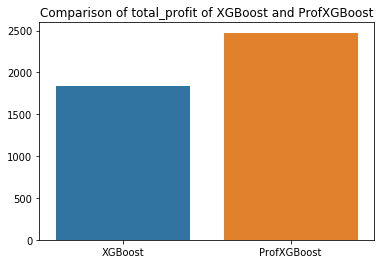

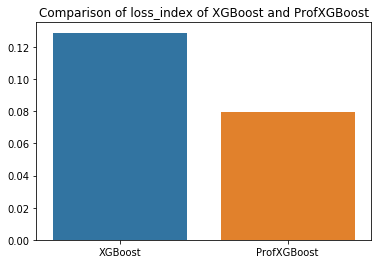

In [155]:
metrics= ['accuracy_score','auc','gini','loss_index', 'total_loss', 'total_profit']
a= metrics_list[model_dict['XGBoost']]['total_profit']
b= metrics_list[model_dict['ProfXGBoost']]['total_profit']

def plot_metric_comparison(metrics_list, x=['XGBoost','ProfXGBoost'],y='total_profit'):
    import matplotlib.pyplot as plt, seaborn as sns
    sns.barplot(x= x,y= [ metrics_list[model_dict[x[0]]][y], metrics_list[model_dict[x[1]]][y]])
    plt.title('Comparison of '+y+' of '+x[0]+' and '+x[1] )
    plt.show()
plot_metric_comparison(metrics_list, x=['XGBoost','ProfXGBoost'],y='total_profit')
plot_metric_comparison(metrics_list, x=['XGBoost','ProfXGBoost'],y='loss_index')


#### 2) Reporting other metrics for XGBoost and ProfXGBoost

In [156]:
metrics= ['accuracy_score','auc','gini','loss_index', 'total_loss', 'total_profit']
def tabulate_metric_comparison(metrics_list, estimators=['XGBoost','ProfXGBoost'], metrics=['auc','accuracy_score']):
    a= metrics_list[model_dict[estimators[0]]][metrics]
    b= metrics_list[model_dict[estimators[1]]][metrics]
    df=pd.DataFrame({estimators[0]: a,estimators[1]: b}).reset_index().rename(columns={'index':'Performance Metric'})
    print(df)
metric_table= tabulate_metric_comparison(metrics_list, estimators=['XGBoost','ProfXGBoost'],metrics= metrics)
metric_table

  Performance Metric   XGBoost ProfXGBoost
0     accuracy_score  0.708645    0.699039
1                auc   0.65319    0.580982
2               gini  0.552256    0.490251
3         loss_index  0.128958   0.0793312
4         total_loss       725         446
5       total_profit      1835        2474


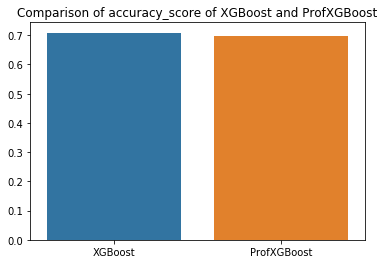

In [157]:
plot_metric_comparison(metrics_list, x=['XGBoost','ProfXGBoost'],y='accuracy_score')

#### Inference: 
- In Total Profit, ProfXGBoost outperforms XGBoost a few times
- In traditional classification metrics like accuracy, XGBoost still performs better than ProfXGBoost

It remains upon the specific use case, which algorithm should be used.


### 1)  Comparison of ProfLogit vs Logistic


#### a) Comparison of Total Profit 

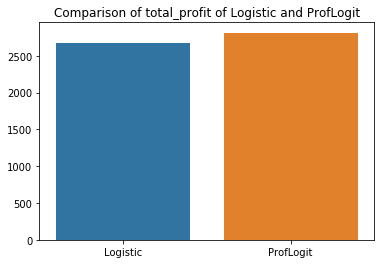

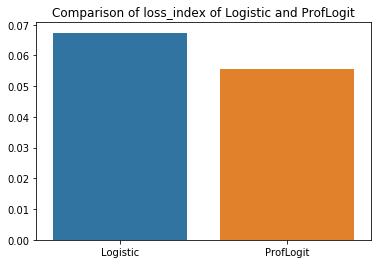

In [158]:
metrics= ['accuracy_score','auc','gini','loss_index', 'total_loss', 'total_profit']
a= metrics_list[model_dict['Logistic']]['total_profit']
b= metrics_list[model_dict['ProfLogit']]['total_profit']

def plot_metric_comparison(metrics_list, x=['Logistic','ProfLogit'],y='total_profit'):
    import matplotlib.pyplot as plt, seaborn as sns
    sns.barplot(x= x,y= [ metrics_list[model_dict[x[0]]][y], metrics_list[model_dict[x[1]]][y]])
    plt.title('Comparison of '+y+' of '+x[0]+' and '+x[1] )
    plt.show()
plot_metric_comparison(metrics_list, x=['Logistic','ProfLogit'],y='total_profit')
plot_metric_comparison(metrics_list, x=['Logistic','ProfLogit'],y='loss_index')


#### 2) Reporting other metrics for XGBoost and ProfXGBoost

In [159]:
metrics= ['accuracy_score','auc','gini','loss_index', 'total_loss', 'total_profit']
def tabulate_metric_comparison(metrics_list, estimators=['Logistic','ProfLogit'], metrics=['auc','accuracy_score']):
    a= metrics_list[model_dict[estimators[0]]][metrics]
    b= metrics_list[model_dict[estimators[1]]][metrics]
    df=pd.DataFrame({estimators[0]: a,estimators[1]: b}).reset_index().rename(columns={'index':'Performance Metric'})
    print(df)
metric_table= tabulate_metric_comparison(metrics_list, estimators=['Logistic','ProfLogit'],metrics= metrics)
metric_table

  Performance Metric   Logistic  ProfLogit
0     accuracy_score   0.659552   0.667022
1                auc   0.500821        0.5
2               gini   0.341733   0.271928
3         loss_index  0.0674137  0.0554963
4         total_loss        379        312
5       total_profit       2671       2813


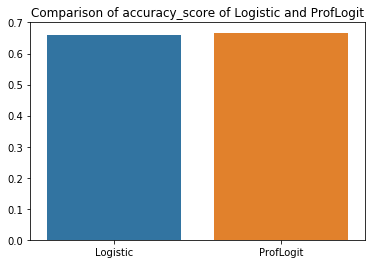

In [160]:
plot_metric_comparison(metrics_list, x=['Logistic','ProfLogit'],y='accuracy_score')

#### Inference: 
- In Total Profit, ProfLogit outperforms Logistic by a bit. Not as strong effect as in XGBoost
- In traditional classification metrics like accuracy, both are comparable


### 3)  Comparison of ProfTree vs Tree


#### a) Comparison of Total Profit 

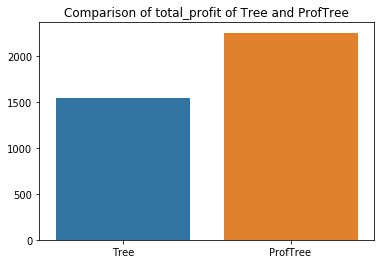

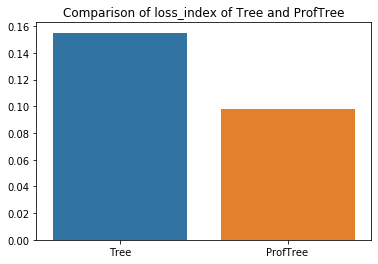

In [161]:
metrics= ['accuracy_score','auc','loss_index', 'total_loss', 'total_profit']
a= metrics_list[model_dict['Tree']]['total_profit']
b= metrics_list[model_dict['ProfTree']]['total_profit']

def plot_metric_comparison(metrics_list, x=['Tree','ProfTree'],y='total_profit'):
    import matplotlib.pyplot as plt, seaborn as sns
    sns.barplot(x= x,y= [ metrics_list[model_dict[x[0]]][y], metrics_list[model_dict[x[1]]][y]])
    plt.title('Comparison of '+y+' of '+x[0]+' and '+x[1] )
    plt.show()
plot_metric_comparison(metrics_list, x=['Tree','ProfTree'],y='total_profit')
plot_metric_comparison(metrics_list, x=['Tree','ProfTree'],y='loss_index')


#### 2) Reporting other metrics for XGBoost and ProfXGBoost

In [162]:
metrics= ['accuracy_score','auc','gini','loss_index', 'total_loss', 'total_profit']
def tabulate_metric_comparison(metrics_list, estimators=['Tree','ProfTree'], metrics=['auc','accuracy_score']):
    a= metrics_list[model_dict[estimators[0]]][metrics]
    b= metrics_list[model_dict[estimators[1]]][metrics]
    df=pd.DataFrame({estimators[0]: a,estimators[1]: b}).reset_index().rename(columns={'index':'Performance Metric'})
    print(df)
metric_table= tabulate_metric_comparison(metrics_list, estimators=['Tree','ProfTree'],metrics= metrics)
metric_table

  Performance Metric      Tree  ProfTree
0     accuracy_score  0.671291  0.686233
1                auc  0.619572   0.58021
2               gini  0.447631  0.338841
3         loss_index  0.155105   0.09783
4         total_loss       872       550
5       total_profit      1548      2255


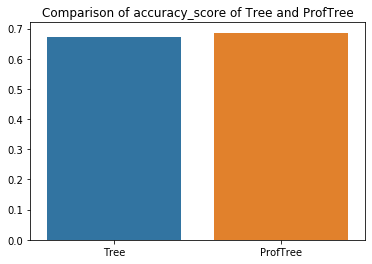

In [163]:
plot_metric_comparison(metrics_list, x=['Tree','ProfTree'],y='accuracy_score')

#### Inference: 
- In Total Profit, ProfTree outperforms Tree a few times
- In traditional classification metrics like accuracy, they are comparable or tree performs slightly better

